# Continuous Control Project Solution

---

**Author:** _Ioannis Souflas_


**Description:**
The objective of this project is to train a Deep Deterministic Policy Gradient (DDPG) agent to control robotic arms using Unity's [Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) enviroment to maintain in contact with the green spheres.

**External References:** [DDPG Algorithm - DeepMind](https://arxiv.org/pdf/1509.02971.pdf) 

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please that you have installed [Unity ML-Agents](https://pypi.org/project/unityagents/), [NumPy](http://www.numpy.org/), [Matplotlib](https://matplotlib.org/), [Collections](https://docs.python.org/2/library/collections.html), [Random](https://docs.python.org/2/library/random.html), [Time](https://docs.python.org/2/library/time.html) and [PyTorch](https://pytorch.org/).

In [1]:
from unityagents import UnityEnvironment 
import numpy as np 
import matplotlib.pyplot as plt
from collections import deque
import random
import time
import torch

# ddpg algorithm
from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

The current configuration is **Linux** (x86_64, headless).

In [2]:
env = UnityEnvironment(file_name="../../p2_continuous-control/Reacher_Linux_NoVis/Reacher.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The shape of the state space looks like:', states.shape)
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The shape of the state space looks like: (20, 33)
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


Note that this enviroment consists of 20 agents, as a results there are 20 different state observations,~ one for each agent.

### 3. DDPG Agent Training Pipeline

The `ddpg` function is making use of the `Agent` class in order to train the agent. Note that the following configuration can be used for both the single and multi (20) agent enviroment.

In [5]:
def ddpg(n_episodes=500, max_t=1000, print_every=1, desired_reward=30.0, moving_average_lentgh=100, train_mode=True):
    
    episode_mean_scores = []                               
    scores_buffer = deque(maxlen=moving_average_lentgh)  
    moving_average = []                              
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] 
        states = env_info.vector_observations                         
        scores = np.zeros(num_agents)                           
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations          
            rewards = env_info.rewards                          
            dones = env_info.local_done                         
            # save experience from each agent to replay buffer
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   
                break
   
        episode_mean_scores.append(np.mean(scores))           
        scores_buffer.append(episode_mean_scores[-1])         
        moving_average.append(np.mean(scores_buffer))    
                
        if i_episode % print_every == 0:
            print('\rEpisode {}\tMean over an Episode: {:.1f}\tMoving Average: {:.1f}'.format(i_episode, episode_mean_scores[-1], moving_average[-1]))
                         
        if moving_average[-1] >= desired_reward and i_episode >= moving_average_lentgh and train_mode==True:
            print('\nAgent trained successfully!\tMoving Average ={:.1f} over the last {} episodes'.format(\
                                    moving_average[-1], moving_average_lentgh))            
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return episode_mean_scores, moving_average

# run the training loop
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
episodic_mean, moving_average = ddpg()

Episode 1	Mean over an Episode: 0.8	Moving Average: 0.8
Episode 2	Mean over an Episode: 2.0	Moving Average: 1.4
Episode 3	Mean over an Episode: 3.9	Moving Average: 2.2
Episode 4	Mean over an Episode: 4.7	Moving Average: 2.9
Episode 5	Mean over an Episode: 5.1	Moving Average: 3.3
Episode 6	Mean over an Episode: 7.0	Moving Average: 3.9
Episode 7	Mean over an Episode: 7.0	Moving Average: 4.4
Episode 8	Mean over an Episode: 7.7	Moving Average: 4.8
Episode 9	Mean over an Episode: 8.8	Moving Average: 5.2
Episode 10	Mean over an Episode: 9.5	Moving Average: 5.6
Episode 11	Mean over an Episode: 10.0	Moving Average: 6.0
Episode 12	Mean over an Episode: 11.4	Moving Average: 6.5
Episode 13	Mean over an Episode: 11.5	Moving Average: 6.9
Episode 14	Mean over an Episode: 14.2	Moving Average: 7.4
Episode 15	Mean over an Episode: 13.7	Moving Average: 7.8
Episode 16	Mean over an Episode: 13.1	Moving Average: 8.1
Episode 17	Mean over an Episode: 14.2	Moving Average: 8.5
Episode 18	Mean over an Episode: 

### 4. Plot of Rewards

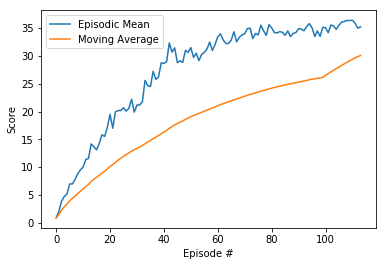

In [6]:
plt.plot(episodic_mean, label='Episodic Mean')
plt.plot(moving_average, label='Moving Average')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env.close()